# Law School Admissions Data - Cleaning

Code to clean self-reported law school admissions data from Law School Numbers.

In [61]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import re
import numpy as np
from collections import ChainMap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


### Import raw data

In [62]:
df_law = pd.read_csv(r'mylsn_raw.csv')
df_law.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,application_id,school,status,sentmonth,decisionmonth,app_id,sent,decision,url,money,lsat,gpa,urm,ed,feewaiver,complete_ts,decision_ts,aa,attending,cycle,state,race,sex,yearsout,schooltype,major,nontrad,international,lgbt,tfa,military,lsat1,lsat2,lsat3
0,2185601,gulc,Ac,11,12,187539,11/07/05,12/01/05,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,1131944400,1133413200,0,0,506,New York,NaN,Female,NaN,NaN,NaN,0,0,0,0,0,173.0,0,0
1,2185600,uva,Ac,10,12,187539,10/12/05,12/07/05,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,1130734800,1133931600,0,0,506,New York,NaN,Female,NaN,NaN,NaN,0,0,0,0,0,173.0,0,0
2,2185599,penn,Ac,11,12,187539,11/01/05,12/16/05,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,1131944400,1134709200,0,0,506,New York,NaN,Female,NaN,NaN,NaN,0,0,0,0,0,173.0,0,0
3,2185598,nyu,Ac,10,0,187539,10/12/05,--,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,1130734800,0,0,0,506,New York,NaN,Female,NaN,NaN,NaN,0,0,0,0,0,173.0,0,0
4,2185597,chicago,Ac,11,2,187539,11/08/05,02/23/06,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,1133413200,1140670800,0,0,506,New York,NaN,Female,NaN,NaN,NaN,0,0,0,0,0,173.0,0,0


In [63]:
len(set(df_law['app_id']))

47683

### Clean categorical data

In [64]:
# What races are listed?
df_law.groupby('race')['race'].count().sort_values(ascending=False)

race
White                   93505
Caucasian               30652
white                   25526
Asian                   12332
Hispanic                9131 
                        ...  
Meat                    1    
egyptians               1    
female/african ameri    1    
nurm                    1    
East Indian/Male        1    
Name: race, Length: 1806, dtype: int64

In [65]:
# Create a list with all the race options
list_race = list(df_law['race'].unique())

# Create a list for each race. Note that each list is mutually exclusive to prevent overlap between lists.
tag_black = list(set([m.group() for l in list_race for m in [re.search(r'.*lack.*|.frican(-)?(\s)?.merican|AA|aa|.*fro.*|BLK|BLACK|.*frican.*|.*FRICA.*', str(l))] if m]))
list_black = list(set([x for x in list_race if x in tag_black]))

list_not_black = [x for x in list_race if x not in list_black]
tag_hispanic = list(set([m.group() for l in list_not_black for m in [re.search(r'.*ispanic.*|.*atin.*|mex.*|Mex.*|.*uerto.*|.*hican.*', str(l))] if m]))
list_hispanic = list(set([x for x in list_not_black if x in tag_hispanic]))

list_not_black_hispanic = [x for x in list_race if x not in list_black + list_hispanic]
tag_asian = list(set([m.group() for l in list_not_black_hispanic for m in [re.search(r'Asian|asian|asian.*|.*outh .*sia.*|india.*|India.*|East|east|.*ilipin.*|.*hinese|.*orea.*', str(l))] if m]))
list_asian = list(set([x for x in list_not_black_hispanic if x in tag_asian]))

list_not_black_hispanic_asian = [x for x in list_race if x not in list_black + list_hispanic + list_asian]
tag_white = list(set([m.group() for l in list_not_black_hispanic_asian for m in [re.search(r'\Dhite\s?.*|w|W|.auc(\D)*', str(l))] if m]))
list_white = list(set([x for x in list_not_black_hispanic_asian if x in tag_white]))

list_other = [x for x in list_race if x not in list_black + list_hispanic + list_asian + list_white]

In [66]:
# Create dict_race and map it over df_law['race']. This will consolidate our race data into 5 categories.
dict_black = {x:'black' for x in list_black}
dict_hispanic = {x:'hispanic' for x in list_hispanic}
dict_asian = {x:'asian' for x in list_asian}
dict_white = {x:'white' for x in list_white}
dict_other = {x: 'other' for x in list_other}

dict_race = {**dict_black, **dict_hispanic, **dict_asian, **dict_white, **dict_other}
df_law['race'] = df_law['race'].map(dict_race)

In [67]:
# There's a separate 'urm' (underrepresented minority) column.
# For any applicant where 'urm' is positive and 'race' is listed as 'white' or 'other', adjust 'race' to 'other_urm'.

df_law['race'] = df_law.apply(lambda x: x['race'].replace('other', 'other_urm') if x['urm'] == 1 else x['race'], axis=1)
df_law['race'] = df_law.apply(lambda x: x['race'].replace('white', 'other_urm') if x['urm'] == 1 else x['race'], axis=1)

In [68]:
# Which races are listed now?
df_law.groupby('race')['race'].count().sort_values(ascending=False)

race
other        201040
white        169216
other_urm    23580 
hispanic     22518 
black        21954 
asian        17043 
Name: race, dtype: int64

In [69]:
# Consolidate 'yearsout'
dict_yearsout = {
    '1-2 Years': '1-2 years',
    'In Undergrad': 'undergrad',
    'in undergrad': 'undergrad',
    '3-4 Years': '3-4 years',
    '5-9 Years': '5-9 years',
    '10+ Years': '10+ years',
    'nan': 'unspecified'
}

df_law['yearsout'] = df_law['yearsout'].map(dict_yearsout)
df_law.groupby('yearsout')['yearsout'].count()

yearsout
1-2 years    86056
10+ years    5806 
3-4 years    38489
5-9 years    22876
undergrad    85864
Name: yearsout, dtype: int64

In [70]:
# Most schools look ok, but these should be consolidated
df_law['school'] = df_law['school'].apply(lambda x: x.replace('arkansas-fayetteville', 'arkansas'))
df_law['school'] = df_law['school'].apply(lambda x: x.replace('rutgers-camden', 'rutgers'))
df_law['school'] = df_law['school'].apply(lambda x: x.replace('rutgers-newark', 'rutgers'))

In [71]:
# Consolidate sexes
df_law['sex'] = df_law['sex'].apply(lambda x: str(x).replace('Female', 'female'))
df_law['sex'] = df_law['sex'].apply(lambda x: str(x).replace('Male', 'male'))
df_law['sex'] = df_law['sex'].apply(lambda x: str(x).replace('nan', 'unspecified'))

In [72]:
# Create a list with all the school type options
list_schooltype = list(df_law['schooltype'].unique())

# Create a list for each schooltype
tag_ivy = list(set([m.group() for l in list_schooltype for m in [re.search(r'.vy.*|.VY|HYP.*|hyp.*|Columbia.*|Yale.*|Harvard.*|Penn|Cornell.*|Brown.*|Dartmouth.*|Princeton.*', str(l))] if m]))
list_ivy = list(set([x for x in list_schooltype if x in tag_ivy]))

list_not_ivy = [x for x in list_schooltype if x not in list_ivy]
tag_liberal = list(set([m.group() for l in list_not_ivy for m in [re.search(r'.*iberal.*', str(l))] if m]))
list_liberal = list(set([x for x in list_not_ivy if x in tag_liberal]))

list_not_ivy_liberal = [x for x in list_schooltype if x not in list_ivy + list_liberal]
tag_public = list(set([m.group() for l in list_not_ivy_liberal for m in [re.search(r'.*ublic.*|.*tate.*|UC.*|uc.*|University of Florida|University of.*|SUNY|CUNY|UVA|UGA|UNC|UT.*|UCF|.*erkeley.*|.utgers.*|.exas.*|.emple.*|.*SU|.*ichigan.*|UW.*|.urdue.*|Indiana.*|Georgia.*|.ervice.*|.lemson.*', str(l))] if m]))
list_public = list(set([x for x in list_not_ivy_liberal if x in tag_public]))

list_not_ivy_liberal_public = [x for x in list_schooltype if x not in list_ivy + list_liberal + list_public]
tag_private = list(set([m.group() for l in list_not_ivy_liberal_public for m in [re.search(r'.*rivate.*|NYU|BYU|Boston.*|GWU|New York University|.yracuse.*|.orthwestern.*|.uke.*|Stanford.*|Vanderbilt.*|Georgetown.*|Emory.*|.op .en|.op 10|.op .ive|.op 5|.op 20|.*otre.*|T20|American.*|.ordham.*|.ulane.*|.righam.*|NESCAC|Jesuit.*|Baylor.*|.*hoenix.*|Washington University.*', str(l))] if m]))
list_private = list(set([x for x in list_not_ivy_liberal_public if x in tag_private]))

list_other_schooltype = [x for x in list_schooltype if x not in list_ivy + list_liberal + list_public + list_private]

In [73]:
# Create dict_schooltype and map it over df_law['schooltype']. This will consolidate our schooltype data into 4 categories.
dict_ivy = {x:'ivy' for x in list_ivy}
dict_public = {x:'public' for x in list_public}
dict_private = {x:'private' for x in list_private}
dict_other_schooltype = {x: 'other' for x in list_other_schooltype}

dict_schooltype = {**dict_ivy, **dict_public, **dict_private, **dict_other_schooltype}
df_law['schooltype'] = df_law['schooltype'].map(dict_schooltype)

In [74]:
# Rename 'state' to 'applicant_state' to specify it's where applicants are from.
# Which states are applicants from?
df_law = df_law.rename(columns={'state': 'applicant_state'})
df_law['applicant_state'].unique()

array(['New York', 'California', 'Georgia', 'Illinois', nan, 'Colorado',
       'Kentucky', 'Virginia', 'Tennessee', 'Missouri', 'Iowa', 'Other',
       'Maryland', 'Ohio', 'Texas', 'Michigan', 'Florida', 'Montana',
       'Connecticut', 'Indiana', 'Alaska', 'Maine', 'Arkansas', 'Utah',
       'North Carolina', 'Louisiana', 'Washington - D.C.',
       'Massachusetts', 'Washington', 'Wisconsin', 'Alabama',
       'Pennsylvania', 'New Jersey', 'South Carolina', 'Kansas',
       'Arizona', 'North Dakota', 'Rhode Island', 'Oregon',
       'South Dakota', 'Oklahoma', 'Minnesota', 'Mississippi', 'Delaware',
       'West Virginia', 'Vermont', 'Nevada', 'New Hampshire',
       'New Mexico', 'Hawaii', 'Nebraska', 'Idaho', 'Wyoming',
       'california', 'new york', 'ohio', 'north carolina', 'washington',
       'virginia', 'missouri', 'new hampshire', 'colorado', 'other',
       'connecticut', 'michigan', 'texas', 'utah', 'georgia', 'florida',
       'washington - d.c.', 'massachusetts', 'kansa

In [75]:
dict_applicant_state = {
    'New York': 'ny',
    'California': 'ca',
    'Georgia': 'ga',
    'Illinois': 'il',
    'Colorado': 'co',
    'Kentucky': 'ky',
    'Virginia': 'va',
    'Tennessee': 'tn',
    'Missouri': 'mo',
    'Iowa': 'ia',
    'Other': 'other',
    'Maryland': 'md',
    'Ohio': 'oh',
    'Texas': 'tx',
    'Michigan': 'mi',
    'Florida': 'fl',
    'Montana': 'mt',
    'Connecticut': 'ct',
    'Indiana': 'in',
    'Alaska': 'ak',
    'Maine': 'me',
    'Arkansas': 'ak',
    'Utah': 'ut',
    'North Carolina': 'nc',
    'Louisiana': 'la',
    'Washington - D.C.': 'dc',
    'Massachusetts': 'ma',
    'Washington': 'wa',
    'Wisconsin': 'wi',
    'Alabama': 'al',
    'Pennsylvania': 'pa',
    'New Jersey': 'nj',
    'South Carolina': 'sc',
    'Kansas': 'ks',
    'Arizona': 'az',
    'North Dakota': 'nd',
    'Rhode Island': 'ri',
    'Oregon': 'or',
    'South Dakota': 'sd',
    'Oklahoma': 'ok',
    'Minnesota': 'mn',
    'Mississippi': 'ms',
    'Delaware': 'de',
    'West Virginia': 'wv',
    'Vermont': 'vt',
    'Nevada': 'nv',
    'New Hampshire': 'nh',
    'New Mexico': 'nm',
    'Hawaii': 'hi',
    'Nebraska': 'ne',
    'Idaho': 'id',
    'Wyoming': 'wy',
    'california': 'ca',
    'new york': 'ny',
    'ohio': 'oh',
    'north carolina': 'nc',
    'washington': 'wa',
    'virginia': 'va',
    'missouri': 'mo',
    'new hampshire': 'nh',
    'colorado': 'co',
    'other': 'other',
    'connecticut': 'ct',
    'michigan': 'mi',
    'texas': 'tx',
    'utah': 'ut',
    'georgia': 'ga',
    'florida': 'fl',
    'washington - d.c.': 'dc', 
    'massachusetts': 'ma',
    'kansas': 'ks',
    'indiana': 'in',
    'pennsylvania': 'pa',
    'arizona': 'az',
    'wisconsin': 'wi',
    'nebraska': 'ne',
    'new jersey': 'nj',
    'illinois': 'il',
    'oregon': 'or',
    'vermont': 'vt',
    'tennessee': 'tn',
    'maryland': 'md',
    'alabama': 'al',
    'kentucky': 'ky',
    'rhode island': 'ri',
    'montana': 'mt',
    'minnesota': 'mn',
    'nevada': 'nv',
    'iowa': 'ia',
    'mississippi': 'ms',
    'south carolina': 'sc',
    'louisiana': 'la',
    'arkansas': 'ak',
    'oklahoma': 'ok',
    'delaware': 'de',
    'south dakota': 'sd',
    'hawaii': 'hi',
    'maine': 'me',
    'idaho': 'id',
    'alaska': 'ak',
    'west virginia': 'wv',
    'new mexico': 'nm',
    'wyoming': 'wy'
}

df_law['applicant_state'] = df_law['applicant_state'].map(dict_applicant_state)

In [76]:
# Create school_state for the state where the college is located

dict_school_state = {
    'gulc': 'dc',
    'uva': 'va',
    'penn': 'pa',
    'nyu': 'ny',
    'chicago': 'il',
    'harvard': 'ma',
    'columbia': 'nu',
    'ucla': 'ca',
    'cornell': 'ny',
    'northwestern': 'il',
    'gw': 'dc',
    'michigan': 'mi',
    'berkeley': 'ca',
    'usc': 'ca',
    'lsu': 'la',
    'mercer': 'ga',
    'loyola-neworleans': 'la',
    'memphis': 'tn',
    'siu': 'il',
    'gsu': 'ga',
    'mississippi': 'ms',
    'stanford': 'ca',
    'yale': 'ct',
    'davis': 'ca',
    'hastings': 'ca',
    'vanderbilt': 'tn',
    'duke': 'nc',
    'wm': 'va',
    'texas': 'tx',
    'wl': 'va',
    'newyork': 'ny',
    'buffalo': 'ny',
    'westernnewengland': 'ma',
    'touro': 'ny',
    'pace': 'ny',
    'cooley': 'mi',
    'suffolk': 'ma',
    'albany': 'ny',
    'stjohns': 'ny',
    'hofstra': 'ny',
    'widener': 'de',
    'newengland': 'ma',
    'emory': 'ga',
    'bc': 'ma',
    'colorado': 'co',
    'niu': 'il',
    'stu': 'fl', 
    'floridacoastal': 'fl',
    'stetson': 'fl',
    'barry': 'fl',
    'phoenix': 'az',
    'johnmarshal-chicago': 'il',
    'nku': 'ky',
    'louisville': 'ky',
    'whittier': 'ca',
    'valparaiso': 'in',
    'pepperdine': 'ca',
    'southwestern': 'ca',
    'brooklyn': 'ny',
    'cardozo': 'ny',
    'fordham': 'ny',
    'gmu': 'va',
    'setonhall': 'nj',
    'rutgers': 'nj',
    'tennessee': 'tn',
    'uconn': 'ct',
    'maryland': 'md',
    'calwestern': 'ca',
    'nccu': 'nc',
    'udc': 'dc',
    'sanfranciso': 'ca',
    'missouri-kc': 'mo',
    'howard': 'dc',
    'nova': 'fl',
    'kansas': 'ks',
    'thomasjefferson': 'ca',
    'westernstate': 'ca',
    'sandiego': 'ca',
    'unc': 'nc',
    'baylor': 'tx',
    'catholic': 'dc',
    'american': 'dc',
    'washu': 'mo',
    'osu': 'oh',
    'bu': 'ma',
    'smu': 'tx',
    'depaul': 'il',
    'msu': 'mi',
    'detroit-mercy': 'mi',
    'wayne': 'mi',
    'fiu': 'fl',
    'indiana': 'in',
    'quinnipiac': 'ct',
    'marquette': 'wi',
    'duquesne': 'pa',
    'indiana-indy': 'in',
    'lewisandclark': 'or',
    'villanova': 'pa',
    'wake': 'nc',
    'northeastern': 'ma',
    'oklahoma': 'ok',
    'capital': 'oh',
    'cincinnati': 'oh',
    'casewestern': 'oh',
    'kentucky': 'oh',
    'utah': 'ut',
    'nevada': 'nv',
    'minnesota': 'mn',
    'temple': 'pa',
    'syracuse': 'ny',
    'arizona': 'az',
    'slu': 'mo',
    'missouri': 'mo',
    'illinois': 'il',
    'notredame': 'in',
    'georgia': 'ga',
    'tulane': 'la',
    'miami': 'fl',
    'santaclara': 'ca',
    'loyola': 'ca',
    'florida': 'fl',
    'fsu': 'fl',
    'seattle': 'wa',
    'houston': 'tx',
    'pacific': 'ca',
    'washington': 'wa',
    'oregon': 'or',
    'asu': 'az',
    'wisconsin': 'wi',
    'gonzaga': 'wa',
    'newhampshire': 'nh',
    'maine': 'me',
    'rogerwilliams': 'ri', 
    'chicago-kent': 'il',
    'arkansas': 'ak',
    'byu': 'ut',
    'wvu': 'wv',
    'iowa': 'ia',
    'loyala-chicago': 'il',
    'pitt': 'pa',
    'alabama': 'al',
    'samford': 'al',
    'richmond': 'va',
    'chapman': 'ca',
    'texastech': 'tx',
    'vermont': 'vt',
    'pennstate': 'pa',
    'denver': 'co',
    'southcarolina': 'sc',
    'hawaii': 'hi',
    'washburn': 'ks',
    'drake': 'ia',
    'creighton': 'ne',
    'dayton': 'oh',
    'baltimore': 'md',
    'regent': 'va',
    'goldengate': 'ca',
    'nebraska': 'ne',
    'avemaria': 'fl',
    'willamette': 'or',
    'tulsa': 'ok',
    'newmexico': 'nm',
    'mississippicollege': 'ms',
    'texasam': 'tx',
    'campbell': 'nc',
    'hamline': 'mn',
    'cuny-queens': 'ny',
    'texassouthern': 'tx',
    'southern': 'la',
    'idaho': 'id',
    'clevelandstate': 'oh',
    'toledo': 'oh',
    'akron': 'oh',
    'ocu': 'ok',
    'southtexas': 'tx',
    'stmarys': 'tx',
    'onu': 'oh',
    'appalachian': 'va',
    'wyoming': 'wy',
    'stthomas': 'mn',
    'montana': 'mt',
    'williammitchell': 'mn',
    'northdakota': 'nd',
    'charleston': 'sc',
    'johnmarshal-atl': 'ga',
    'southdakota': 'sd',
    'charlotte': 'nc',
    'drexel': 'pa',
    'famu': 'fl',
    'jones': 'al',
    'elon': 'nc',
    'nashville': 'tn',
    'laverne': 'ca',
    'interamerican': 'pr',
    'pontifical': 'pr',
    'puertorico': 'pr',
    'toronto': 'on',
    'irvine': 'ca',
    'dalhousie': 'ns',
    'brittishcolumbia': 'bc',
    'calgary': 'ab',
    'ottawa': 'on',
    'queens': 'on',
    'york': 'on',
    'saskatchewan': 'sk',
    'liberty': 'va',
    'alberta': 'ab',
    'westernontario': 'on',
    'windsor': 'on',
    'mcgill': 'qc',
    'manitoba': 'mb',
    'victoria': 'bc',
    'newbrunswick': 'nb',
    'massachusetts': 'ma',
    'belmont': 'tn'
}

df_law['school_state'] = df_law['school'].map(dict_school_state)

In [77]:
# What majors are listed?
df_law.groupby('major')['major'].count().sort_values(ascending=False)

major
Political Science                 34736
History                           14505
English                           11774
Economics                         11556
Philosophy                        8018 
                                  ...  
interior design/architecture      1    
Econ &amp; Phil                   1    
International Affairs / Arabic    1    
Poli-Scie and Theatre             1    
poltical science                  1    
Name: major, Length: 7436, dtype: int64

In [78]:
# Create a list with all the major options
list_major = list(df_law['major'].unique())

# Create a list for each major
tag_polisci = list(set([m.group() for l in list_major for m in [re.search(r'.*olitical.*|.*Pol.*|.*pol.*|.*olitics.*', str(l))] if m]))
list_polisci = list(set([x for x in list_major if x in tag_polisci]))

tag_history = list(set([m.group() for l in list_major for m in [re.search(r'.*ist.*', str(l))] if m]))
list_history = list(set([x for x in list_major if x in tag_history]))

tag_english = list(set([m.group() for l in list_major for m in [re.search(r'.*nglish.*|.it.*|.* .it|.riting|.*ompar.*', str(l))] if m]))
list_english = list(set([x for x in list_major if x in tag_english]))

tag_econ = list(set([m.group() for l in list_major for m in [re.search(r'.*econ.*|.*Econ.*', str(l))] if m]))
list_econ = list(set([x for x in list_major if x in tag_econ]))

tag_phil = list(set([m.group() for l in list_major for m in [re.search(r'.*phil.*|.*Phil.*', str(l))] if m]))
list_phil = list(set([x for x in list_major if x in tag_phil]))

tag_psych = list(set([m.group() for l in list_major for m in [re.search(r'.*syc.*', str(l))] if m]))
list_psych = list(set([x for x in list_major if x in tag_psych]))

tag_biz = list(set([m.group() for l in list_major for m in [re.search(r'.*inanc.*|.ccounting|acct|.ax.*|.*usiness.*|.*dmin.*|.*dvert.*|.*arketing.*|mktg|.*anagement.*|.*rgan.*|.*mgmt.*|.*iz.*', str(l))] if m]))
list_biz = list(set([x for x in list_major if x in tag_biz]))

tag_cj = list(set([m.group() for l in list_major for m in [re.search(r'.*cj.*|.*CJ.*|.*rim.*|.RIM.*|.*ustic.*', str(l))] if m]))
list_cj = list(set([x for x in list_major if x in tag_cj]))

tag_govt = list(set([m.group() for l in list_major for m in [re.search(r'.ov.*|.*olicy.*|.*ublic.*|.*gov.*|.*Gov.*|.*iploma.*|.*lobal.*|.ntl.*|.nternational.*|.oreign.*|IR|ir', str(l))] if m]))
list_govt = list(set([x for x in list_major if x in tag_govt]))

tag_humanities = list(set([m.group() for l in list_major for m in [re.search(r'.*ociol.*|.*uman.*|.*iberal.*|.ocial.*|.*usic.*|.*nthro.*|.* .elation.*|.*tudies|.*lassi.*|.*panish.*|.*rchitec.*|.*elig.*|.*iddle.*|.rabic.*|.*heat.*|.*art.*|.*Art.*|.*rama.*|.*rench.*|.*erman.*|.*ussian.*|.port.*|.*edu.*|.*Edu.*|.*heology.*|.*ilm.*|.*urop.*|.*hinese.*|.*sian.*|.*atin.*|.*east.*|.*East.*|.*apan.*|.*omen.*|.*ender.*|.*frica.*|.*inguist.*|.omm.*|.*omm|.*ommun.*|.*adio.*|.*tv.*|.*elevision.*|.*hetoric.*|.roadc.*|.*elecom.*|.*ournal.*|PR|pr|.*edia.*', str(l))] if m]))
list_humanities = list(set([x for x in list_major if x in tag_humanities]))

tag_law = list(set([m.group() for l in list_major for m in [re.search(r'.*aw.*|.*egal.*|.re .aw|.re-?.aw', str(l))] if m]))
list_law = list(set([x for x in list_major if x in tag_law]))

tag_stem = list(set([m.group() for l in list_major for m in [re.search(r'.*ng.*|.omputer.*|EE.*|ee.*|CS.*|cs.*|.lectical.*|.*ompu.*|.omp .ci.*|.io.*|.*bio.*|.*Bio.*|STEM|.tem.*|.*hem.*|.*hysic.*|.*cience.*|.*euro.*|.*ath.*|.*harm.*|.*enetic.*|.*cology*|.*oology.*|.*tatistic.*|.tats|.*nfo.*|.*uant.*|.*inesiology.*|.*pplied.*|.*otany.*|.*eology.*|.*nviron.*|.*med.*|.*Med.*|.*olecu.*|.*gri.*|.*orest.*|.*graphy.*|.*tech.*|.*Tech.*|.*aero.*|.*Aero.*|.*ealth.*|.*ogni.*|.*nerg.*|.*atur.*|.*arine.*', str(l))] if m]))
list_stem = list(set([x for x in list_major if x in tag_stem]))

list_top_majors = [list_polisci, list_history, list_english, list_econ, list_phil, list_psych, list_biz, list_cj, list_govt, list_humanities, list_law, list_stem]

list_other = [x for x in list_major if x not in [i for sublist in list_top_majors for i in sublist]]

In [79]:
# Create dict_major and map it over df_law['major']. This will consolidate our major data.

dict_polisci = {x:'political science' for x in list_polisci}
dict_history = {x:'history' for x in list_history}
dict_english = {x:'english' for x in list_english}
dict_econ = {x:'economics' for x in list_econ}
dict_phil = {x:'philosophy' for x in list_phil}
dict_psych = {x:'psychology' for x in list_psych}
dict_biz = {x:'business' for x in list_biz}
dict_cj = {x:'criminal justice' for x in list_cj}
dict_govt = {x:'government' for x in list_govt}
dict_humanities = {x:'humanities' for x in list_humanities}
dict_law = {x:'law' for x in list_law}
dict_stem = {x:'stem' for x in list_stem}
dict_other = {x:'other' for x in list_other}

list_dict_major = [dict_polisci, dict_history, dict_english, dict_econ, dict_phil, dict_psych, dict_biz, dict_cj, dict_govt, dict_humanities, dict_law, dict_stem, dict_other]
dict_major = dict(ChainMap(*list_dict_major))
df_law['major'] = df_law['major'].map(dict_major)

In [80]:
df_law.groupby('major')['major'].count().sort_values(ascending=False)

major
other                144997
political science    87374 
humanities           39569 
stem                 31439 
history              31148 
business             29445 
economics            22828 
english              19592 
psychology           12995 
government           12966 
philosophy           12672 
criminal justice     8416  
law                  1910  
Name: major, dtype: int64

In [81]:
# What is listed under 'status'?
df_law['status'].unique()

array(['Ac', 'Re', 'Pe', 'Wa', 'AcWa', 'ReWa'], dtype=object)

In [82]:
# For the sake of this analysis, status will be 1 if 'accepted', 0 if 'rejected', 'waitlisted', or 'pending'.

dict_status = {
    'Ac': 1,
    'Re': 0,
    'Pe': 0, # this means pending (the school didn't respond or the applicant didn't update with their admissions results)
    'Wa': 0,
    'AcWa': 1, # this means waitlisted and then accepted from the waitlist
    'ReWa': 0 # this means waitlisted and then rejected from the waitlist
}

df_law['status'] = df_law['status'].map(dict_status)

In [ ]:
# Parse the 'sent' and 'decision' dates, but almost half the values are missing so they may be ignored in the analysis
df_law['sent'] = df_law['sent'].apply(lambda x: None if x == '--' else pd.to_datetime(x, format = '%m/%d/%y'))
df_law['decision'] = df_law['decision'].apply(lambda x: None if x == '--' else pd.to_datetime(x, format = '%m/%d/%y'))

In [ ]:
# Drop unnecessary columns & rename some columns
df_law = df_law.drop(['complete_ts', 'decision_ts', 'aa', 'urm', 'lsat1', 'lsat2', 'lsat3', 'cycle'], axis=1)
df_law = df_law.rename(columns={'status': 'accepted', 'sentmonth': 'sent_month', 'decisionmonth': 'decision_month', 'app_id': 'applicant_id', 'money': 'scholarship', 'ed':'early_decision', 'nontrad': 'nontraditional', 'feewaiver': 'fee_waiver', 'yearsout': 'years_out', 'schooltype': 'school_type'})

In [ ]:
df_law.head()

In [ ]:
df_law = df_law.drop(['application_id','applicant_id','sent','decision','url','scholarship','attending',
                     'years_out'],axis=1)

### Save df_law to csv

In [ ]:
df_law.to_csv(r'lawschool_clean.csv')

(array([144997.,  87374.,  19592.,  39569.,  12995.,  31439.,   8416.,
         31148.,  22828.,  29445.,  12966.,  12672.,   1910.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]),
 <a list of 13 Patch objects>)

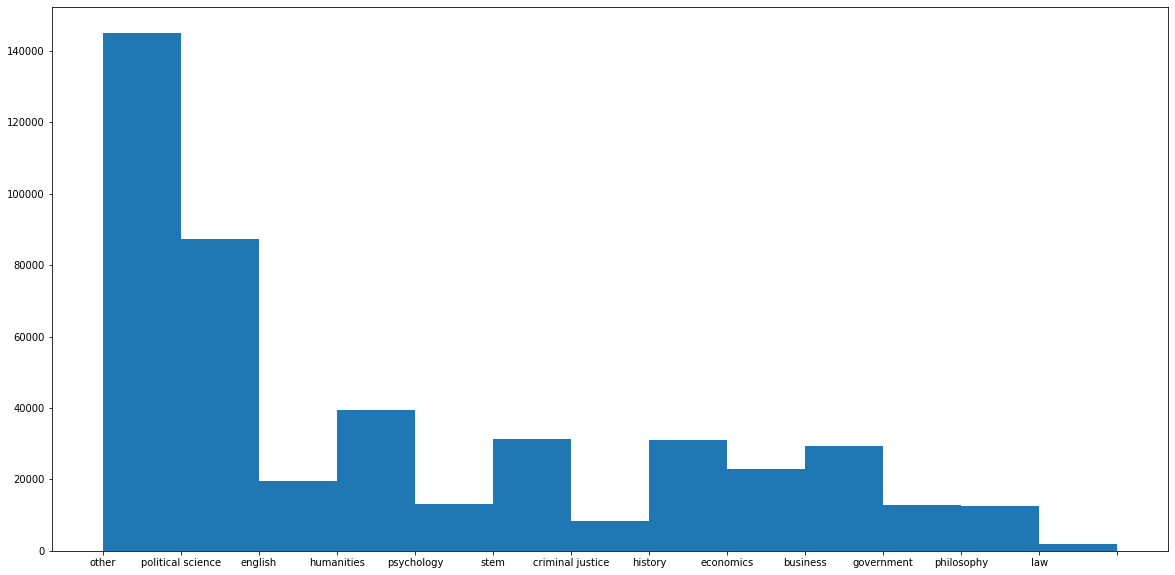

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.hist(df_law['major'],bins = list(Counter(df_law['major']).keys()) + [''])


In [58]:
from collections import Counter
Counter(df_law['major'])

Counter({'other': 144997,
         'political science': 87374,
         'english': 19592,
         'humanities': 39569,
         'psychology': 12995,
         'stem': 31439,
         'criminal justice': 8416,
         'history': 31148,
         'economics': 22828,
         'business': 29445,
         'government': 12966,
         'philosophy': 12672,
         'law': 1910})